In [1]:
from argparse import Namespace
import numpy as np
from spotPython.spot import spot
from main import main as objective_function # NOTE: you need to add a return statement to the main function
from typing import Optional, Dict
from scipy.optimize import differential_evolution

import main

from neat.activations import ActivationFunctionSet
from neat.aggregations import AggregationFunctionSet


from neat.genes import DefaultConnectionGene, DefaultNodeGene


from itertools import count


from spotPython.fun.objectivefunctions import analytical

In [2]:
class DummyGenomeConfig:
    def __init__(self):
        self.node_indexer = count(1)

    def get_new_node_key(self, node_dict):
        return next(self.node_indexer)
    
    def check_structural_mutation_surer(self):
        if self.structural_mutation_surer == 'true':
            return True
        elif self.structural_mutation_surer == 'false':
            return False
        elif self.structural_mutation_surer == 'default':
            return self.single_structural_mutation
        else:
            error_string = f"Invalid structural_mutation_surer {self.structural_mutation_surer!r}"
            raise RuntimeError(error_string)

In [3]:
def mbf_objective(config: Namespace, n_runs: int = 20, verbose: int = 0):
    epoch_callback = None #lambda fitness, evals: callback(trial, fitness,evals)
    fitness = 0.0
    mins, maxs, means, sizes_nodes, sizes_connections, all_fitnesses = [],[],[],[],[],[]
    for i in range(n_runs):
        iter_fitness, maxs_curr, means_curr, mins_curr, net_size_nodes, net_size_connections, all_fitness = main.main(callback=epoch_callback, plot=False, config_in = config, verbose=verbose)
        fitness += iter_fitness
        mins.append(mins_curr)
        maxs.append(maxs_curr)
        means.append(means_curr)
        sizes_connections.append(net_size_connections)
        sizes_nodes.append(net_size_nodes)
        all_fitnesses.append(all_fitness)

    fitness_avg = fitness/n_runs

    # save_trial(trial._trial_id, config, maxs, mins, means, sizes_nodes, sizes_connections, all_fitnesses, study_name)
    return fitness_avg

In [4]:
def objective(X: np.ndarray, fun_control: Optional[Dict] = None):
    config = Namespace()
    config.genome_config = DummyGenomeConfig()
    config.POPULATION_SIZE = 50#trial.suggest_int("POP_SIZE", 10,50)
    config.OFFSPRING_SIZE = 10 #int(config.POPULATION_SIZE  * trial.suggest_float("OFFSPRING_FRAC", 0.1,1))
    config.NUM_EVALS = 200
    config.NUM_GENERATIONS = 100 #(config.NUM_EVALS-config.POPULATION_SIZE) / config.OFFSPRING_SIZE


    #These are normally provided in neat's config file
    config.genome_config.activation_default      = "sigmoid"
    config.genome_config.activation_mutate_rate  = 0.0
    config.genome_config.activation_options      = "sigmoid"
    # node aggregation options
    config.genome_config.aggregation_default     = "sum"
    config.genome_config.aggregation_mutate_rate = 0.0
    config.genome_config.aggregation_options     = "sum"
    # node bias options
    config.genome_config.bias_init_mean          = 0.0
    config.genome_config.bias_init_stdev         = 1.0
    config.genome_config.bias_max_value          = 30.0
    config.genome_config.bias_min_value          = -30.0
    # config.genome_config.bias_mutate_power       = trial.suggest_float("bias_mutate_power", 0.1,2)
    config.genome_config.bias_mutate_rate        = 0.7
    # config.genome_config.bias_replace_rate       = trial.suggest_float("bias_replace_rate", 0.0,1)
    # genome compatibility options
    config.genome_config.compatibility_disjoint_coefficient = 1.0
    config.genome_config.compatibility_weight_coefficient   = 0.5
    # connection add/remove rates
    # config.genome_config.conn_add_prob           = trial.suggest_float("conn_add_prob", 0.0,1)
    # config.genome_config.conn_delete_prob        = trial.suggest_float("conn_delete_prob", 0.0,1)
    # connection enable options
    config.genome_config.enabled_default         = True
    config.genome_config.enabled_mutate_rate     = 0.01
    config.genome_config.feed_forward            = True
    config.genome_config.initial_connection      = "full_direct"
    # node add/remove rates
    # config.genome_config.node_add_prob           = trial.suggest_float("node_add_prob", 0.1,1)
    # config.genome_config.node_delete_prob        = trial.suggest_float("node_delete_prob", 0.1,1)
    # network parameters
    config.genome_config.num_hidden              = 1
    config.genome_config.num_inputs              = 4
    config.genome_config.num_outputs             = 1
    # node response options
    config.genome_config.response_init_mean      = 1.0
    config.genome_config.response_init_stdev     = 0.0
    config.genome_config.response_max_value      = 30.0
    config.genome_config.response_min_value      = -30.0
    config.genome_config.response_mutate_power   = 0.0
    config.genome_config.response_mutate_rate    = 0.0
    config.genome_config.response_replace_rate   = 0.0
    # connection weight options
    config.genome_config.weight_init_mean        = 0.0
    config.genome_config.weight_init_stdev       = 1.0
    config.genome_config.weight_max_value        = 30
    config.genome_config.weight_min_value        = -30
    config.genome_config.weight_mutate_power     = 0.5
    config.genome_config.weight_mutate_rate      = 0.8
    config.genome_config.weight_replace_rate     = 0.1

    #these are needed besides the params that come from the file
    config.genome_config.output_keys = [i for i in range(config.genome_config.num_outputs)]
    config.genome_config.input_keys = [-i - 1 for i in range(config.genome_config.num_inputs)]
    config.genome_config.node_gene_type = DefaultNodeGene
    config.genome_config.connection_gene_type   = DefaultConnectionGene
    config.genome_config.bias_init_type = "gaussian"
    config.genome_config.response_init_type = "gaussian"
    config.genome_config.weight_init_type = "gaussian"
    config.genome_config.activation_defs = ActivationFunctionSet()
    config.genome_config.aggregation_function_defs = AggregationFunctionSet()
    config.genome_config.aggregation_defs =  config.genome_config.aggregation_function_defs
    config.genome_config.single_structural_mutation= False
    config.genome_config.enabled_rate_to_false_add= 0.0
    config.genome_config.enabled_rate_to_true_add=0.0
    config.genome_config.structural_mutation_surer='default'

    # Initialize an empty numpy array for y
    y = np.empty((0, 1))
    for row in X:
        # modify the related parameters in the config file
        config.genome_config.bias_mutate_power       = row[0]
        config.genome_config.bias_replace_rate       = row[1]
        config.genome_config.conn_add_prob           = row[2]
        config.genome_config.conn_delete_prob        = row[3]
        config.genome_config.node_add_prob           = row[4]
        config.genome_config.node_delete_prob        = row[5]
        
        # run the objective (mbf over 20 runs)
        fitness = - mbf_objective(config, n_runs=20, verbose=0) # NOTE: spot minimizes the objective function, so we need to negate it
        # Append the fitness to y
        y = np.append(y, fitness)

    return y

In [9]:
lower = np.array([0.1, 0.0, 0.0, 0.0, 0.1, 0.1])
upper = np.array([2, 1, 1.0, 1.0, 1.0, 1.0])

spot_model = spot.Spot(fun=objective, # objective function
                    lower = lower, # lower bound of the search space
                    upper = upper, # upper bound of the search space
                fun_evals= 15, # TODO change
                max_time= 10, # 10 minutes
                var_name=["bias_mutate_power", 
                            "bias_replace_rate",
                            "conn_add_prob",
                            "conn_delete_prob",
                            "node_add_prob",
                            "node_delete_prob"
                            ], # name of the variables 
                show_progress=True, 
                surrogate_control={"n_theta": 6, 
                    "model_optimizer": differential_evolution,
                    },
                # fun_control= fun_control,
                )


In [10]:
spot_model.run(X_start=np.array([[0.5, 0.1, 0.2, 0.2, 0.2, 0.2]]),) # initial design points

[2023-10-31 23:04:56,575] [INFO] [main] Generating initial population.
[2023-10-31 23:04:58,248] [INFO] [logging] =======================================
[2023-10-31 23:04:58,249] [INFO] [logging] =======================================
[2023-10-31 23:04:58,249] [INFO] [logging] =======================================
[2023-10-31 23:04:58,249] [INFO] [logging] New log starts here.
[2023-10-31 23:04:58,249] [INFO] [logging] =======================================
[2023-10-31 23:04:58,249] [INFO] [logging] =======================================
[2023-10-31 23:04:58,250] [INFO] [logging] =======================================
[2023-10-31 23:04:58,250] [INFO] [main] Using config_in
[2023-10-31 23:04:58,250] [INFO] [rng] Rng seed: 1698789898250374
[2023-10-31 23:04:58,250] [INFO] [main] Generating initial population.
[2023-10-31 23:05:01,098] [INFO] [logging] =======================================
[2023-10-31 23:05:01,098] [INFO] [logging] =======================================
[2023-10

what's returned from fun:  [-43.05    -3.2135  -4.154  -37.1915  -9.259  -15.929  -16.401  -17.9245
 -23.099  -14.352  -18.1825]


[2023-10-31 23:10:28,446] [INFO] [logging] =======================================
[2023-10-31 23:10:28,447] [INFO] [logging] =======================================
[2023-10-31 23:10:28,447] [INFO] [logging] =======================================
[2023-10-31 23:10:28,447] [INFO] [logging] New log starts here.
[2023-10-31 23:10:28,447] [INFO] [logging] =======================================
[2023-10-31 23:10:28,447] [INFO] [logging] =======================================
[2023-10-31 23:10:28,448] [INFO] [logging] =======================================
[2023-10-31 23:10:28,448] [INFO] [main] Using config_in
[2023-10-31 23:10:28,448] [INFO] [rng] Rng seed: 1698790228448569
[2023-10-31 23:10:28,448] [INFO] [main] Generating initial population.
[2023-10-31 23:10:31,451] [INFO] [logging] =======================================
[2023-10-31 23:10:31,452] [INFO] [logging] =======================================
[2023-10-31 23:10:31,452] [INFO] [logging] ====================================

spotPython tuning: -43.04999999999778 [########--] 80.00% 


[2023-10-31 23:11:20,906] [INFO] [logging] =======================================
[2023-10-31 23:11:20,906] [INFO] [logging] =======================================
[2023-10-31 23:11:20,907] [INFO] [logging] =======================================
[2023-10-31 23:11:20,907] [INFO] [logging] New log starts here.
[2023-10-31 23:11:20,907] [INFO] [logging] =======================================
[2023-10-31 23:11:20,907] [INFO] [logging] =======================================
[2023-10-31 23:11:20,907] [INFO] [logging] =======================================
[2023-10-31 23:11:20,907] [INFO] [main] Using config_in
[2023-10-31 23:11:20,908] [INFO] [rng] Rng seed: 1698790280908012
[2023-10-31 23:11:20,908] [INFO] [main] Generating initial population.
[2023-10-31 23:11:22,602] [INFO] [logging] =======================================
[2023-10-31 23:11:22,602] [INFO] [logging] =======================================
[2023-10-31 23:11:22,602] [INFO] [logging] ====================================

spotPython tuning: -47.21349999999769 [#########-] 86.67% 


[2023-10-31 23:12:02,929] [INFO] [logging] =======================================
[2023-10-31 23:12:02,929] [INFO] [logging] =======================================
[2023-10-31 23:12:02,929] [INFO] [logging] =======================================
[2023-10-31 23:12:02,929] [INFO] [logging] New log starts here.
[2023-10-31 23:12:02,930] [INFO] [logging] =======================================
[2023-10-31 23:12:02,930] [INFO] [logging] =======================================
[2023-10-31 23:12:02,930] [INFO] [logging] =======================================
[2023-10-31 23:12:02,930] [INFO] [main] Using config_in
[2023-10-31 23:12:02,930] [INFO] [rng] Rng seed: 1698790322930769
[2023-10-31 23:12:02,930] [INFO] [main] Generating initial population.
[2023-10-31 23:12:04,970] [INFO] [logging] =======================================
[2023-10-31 23:12:04,971] [INFO] [logging] =======================================
[2023-10-31 23:12:04,971] [INFO] [logging] ====================================

spotPython tuning: -47.21349999999769 [#########-] 93.33% 


[2023-10-31 23:12:40,361] [INFO] [logging] =======================================
[2023-10-31 23:12:40,361] [INFO] [logging] =======================================
[2023-10-31 23:12:40,361] [INFO] [logging] =======================================
[2023-10-31 23:12:40,361] [INFO] [logging] New log starts here.
[2023-10-31 23:12:40,362] [INFO] [logging] =======================================
[2023-10-31 23:12:40,362] [INFO] [logging] =======================================
[2023-10-31 23:12:40,362] [INFO] [logging] =======================================
[2023-10-31 23:12:40,362] [INFO] [main] Using config_in
[2023-10-31 23:12:40,362] [INFO] [rng] Rng seed: 1698790360362865
[2023-10-31 23:12:40,363] [INFO] [main] Generating initial population.
[2023-10-31 23:12:42,977] [INFO] [logging] =======================================
[2023-10-31 23:12:42,977] [INFO] [logging] =======================================
[2023-10-31 23:12:42,978] [INFO] [logging] ====================================

spotPython tuning: -47.21349999999769 [##########] 100.00% Done...



In [11]:
spot_model.print_results()

min y: -47.21349999999769
bias_mutate_power: 0.6078890988180532
bias_replace_rate: 0.15393469242600846
conn_add_prob: 0.2937506980509848
conn_delete_prob: 0.24518377993242882
node_add_prob: 0.16537661576374013
node_delete_prob: 0.19909848890840057


[['bias_mutate_power', 0.6078890988180532],
 ['bias_replace_rate', 0.15393469242600846],
 ['conn_add_prob', 0.2937506980509848],
 ['conn_delete_prob', 0.24518377993242882],
 ['node_add_prob', 0.16537661576374013],
 ['node_delete_prob', 0.19909848890840057]]

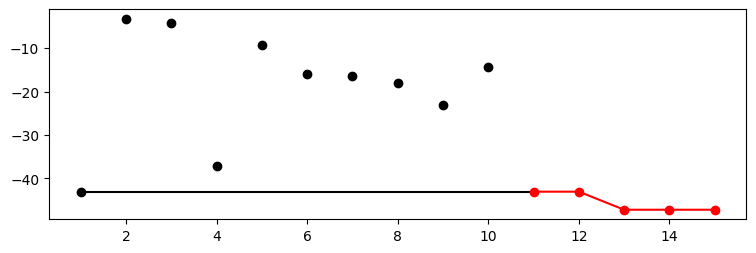

In [13]:
spot_model.plot_progress()


In [26]:
spot_model.print_importance()


conn_add_prob:  5.555789095099557
node_add_prob:  100.0
node_delete_prob:  7.992997358805733


[['bias_mutate_power', 0.0028803124068864476],
 ['bias_replace_rate', 0.0028803124068864476],
 ['conn_add_prob', 5.555789095099557],
 ['conn_delete_prob', 0.0028803124068864476],
 ['node_add_prob', 100.0],
 ['node_delete_prob', 7.992997358805733]]

Based on the model created, it can be seen that "node_add_prob", "node_delete_prob" and "conn_add_prob" are important for the model.

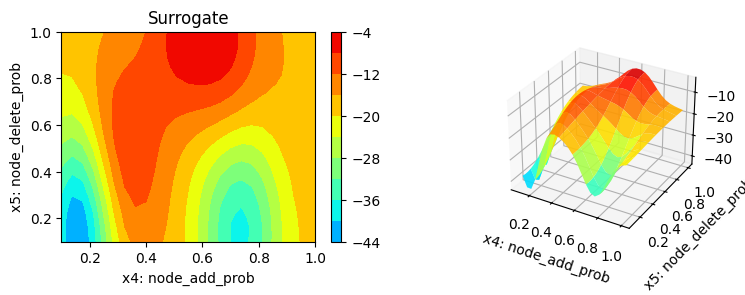

In [27]:
spot_model.plot_contour(i=4, j=5, min_z = -60, max_z = 0)


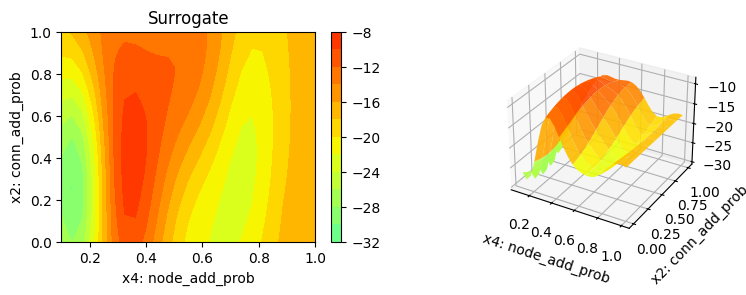

In [28]:
spot_model.plot_contour(i=4, j=2, min_z = -60, max_z = 0)


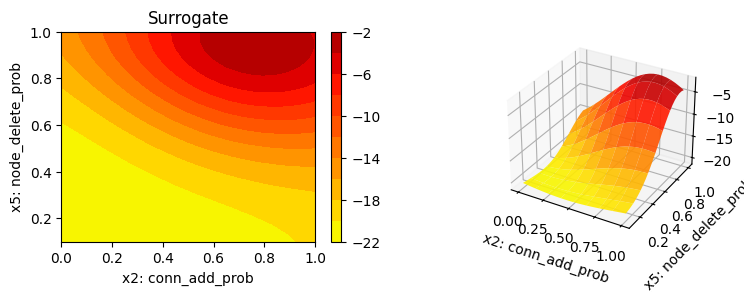

In [29]:
spot_model.plot_contour(i=2, j=5, min_z = -60, max_z = 0)
